# Using multiple structures for ABPP Cys to predict

In [27]:
import gc
import copy
import random
import pandas as pd
import numpy as np
from collections import defaultdict
from pycaret.classification import setup, create_model, tune_model, predict_model, add_metric, get_config, load_model, plot_model, pull, save_model
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, make_scorer, roc_auc_score, average_precision_score, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy import stats
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score
def selectivity_score(y_true, y_pred):
    return recall_score(y_true
                        , y_pred
                        , pos_label=0
                        , zero_division=1)
def npv_score(y_true, y_pred):
    return precision_score(y_true
                        , y_pred
                        , pos_label=0
                        , zero_division=1)
random.seed(0)
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
mpl.rcParams['figure.dpi']= 600
sns.set_palette('deep')
sns.set_style("whitegrid", {'axes.grid' : False})
font = {
        'weight' : 'normal',
        'size'   : 10
    }

bacc = make_scorer(balanced_accuracy_score, adjusted=True)
np.random.seed(123)


## 1. Load  data and construct the final ABPP test sets for comparison

In [2]:
df_cov = pd.read_csv('covl_allmodi_and_sampled10to4_nodisulfide.csv')
df_cov['uniprot_residue'] = df_cov.apply(lambda x: f'{x.uniprot_id}_C{x.uniprot_resid}', axis=1)
cov_cys = set(df_cov.uniprot_residue)
cov_pos_cys = set(df_cov[df_cov.label].uniprot_residue)
cov_neg_cys = set(df_cov[~df_cov.label].uniprot_residue)
print("Number of total, positive, and negative UNIQUE Cys in the whole LigCysDB dataset:")
len(cov_cys), len(cov_pos_cys), len(cov_neg_cys)

Number of total, positive, and negative UNIQUE Cys in the whole LigCysDB dataset:


(4217, 1133, 3084)

In [3]:
print("Number of total, positive, and negative Cys ETNTRIES in the whole LigCysDB dataset:")
len(df_cov), len(df_cov[df_cov.label]), len(df_cov[~df_cov.label])

Number of total, positive, and negative Cys ETNTRIES in the whole LigCysDB dataset:


(20259, 9992, 10267)

In [4]:
dfc = df_cov[df_cov.in_dataset == 'Cov']
dfl = df_cov[df_cov.in_dataset == 'Lpeptide']

In [5]:
len(set(dfc.uniprot_residue)),\
len(set(dfc[dfc.label].uniprot_residue)),\
len(set(dfc[~dfc.label].uniprot_residue))

(3087, 662, 2425)

In [6]:
len(set(dfl.uniprot_residue)),\
len(set(dfl[dfl.label].uniprot_residue)),\
len(set(dfl[~dfl.label].uniprot_residue))

(1140, 472, 668)

In [7]:
len(set(dfc.uniprot_id)),\
len(set(dfc[dfc.label].uniprot_id)),\
len(set(dfc[~dfc.label].uniprot_id))

(489, 489, 401)

In [8]:
len(set(dfl.uniprot_id)),\
len(set(dfl[dfl.label].uniprot_id)),\
len(set(dfl[~dfl.label].uniprot_id))

(299, 294, 136)

In [9]:
df_backus_pdb_unique = pd.read_csv('backus_pdb_test_set.csv')
df_backus_af2 = pd.read_csv('backus_af2_test_set.csv')
backus_cys = set(df_backus_pdb_unique.uniprot_residue)
backus_pos_cys = set(df_backus_pdb_unique[df_backus_pdb_unique.label].uniprot_residue)
backus_neg_cys = set(df_backus_pdb_unique[~df_backus_pdb_unique.label].uniprot_residue)
print("Number of total, positive, and negative Cys in original ABPP test set:")
len(backus_cys), len(backus_pos_cys), len(backus_neg_cys)

Number of total, positive, and negative Cys in original ABPP test set:


(629, 190, 439)

In [85]:
len(set(df_backus_pdb_unique.uniprot_id)), \
len(set(df_backus_pdb_unique[df_backus_pdb_unique.label].uniprot_id)),\
len(set(df_backus_pdb_unique[~df_backus_pdb_unique.label].uniprot_id))

(399, 160, 270)

In [10]:
print("Our ABPP unique PDB and AF2 test sets cover the exactly same Cys.")
backus_cys == set(df_backus_af2.uniprot_residue),\
backus_pos_cys == set(df_backus_af2[df_backus_af2.label].uniprot_residue),\
backus_neg_cys == set(df_backus_af2[~df_backus_af2.label].uniprot_residue),\

Our ABPP unique PDB and AF2 test sets cover the exactly same Cys.


(True, True, True)

In [11]:
print("Our ABPP test data is not in the LigCysDB.")
len(df_backus_pdb_unique[df_backus_pdb_unique.uniprot_residue.isin(df_cov.uniprot_residue)])

Our ABPP test data is not in the LigCysDB.


0

In [12]:
# The following datasets can generate Cys with multiple structures.

# Monomer
df_backus_mono = pd.read_csv('backus_pos_monomer.csv')
df_backus_mono['uniprot_residue'] = df_backus_mono.apply(lambda x: f'{x.uniprot_id.split("-")[0]}_C{x.uniprot_resid}', axis=1)

# Dimer
df_backus_dimer = pd.read_csv('backus_pos_dimer.csv')
df_backus_dimer['uniprot_residue'] = df_backus_dimer.apply(lambda x: f'{x.uniprot_id.split("-")[0]}_C{x.uniprot_resid}', axis=1)

# Together
df_backus_monodimer = pd.concat([df_backus_mono, df_backus_dimer], axis=0)

# Only choose those in df_backus_pdb_unique positives.
df_backus_monodimer_pos = df_backus_monodimer[df_backus_monodimer.uniprot_residue.isin(backus_pos_cys)]

# Find the negatives in the mono and dimer, and also choose only in df_backus_pdb_unique negatives.
df_backus_monodimer_neg = pd.read_csv('/home/rliu/projects/abpp_cys/mul/final_full_df.csv')
df_backus_monodimer_neg['uniprot_residue'] = df_backus_monodimer_neg.apply(lambda x: f'{x.uniprot_id}_C{x.uniprot_resid}', axis=1)
df_backus_monodimer_neg = df_backus_monodimer_neg[df_backus_monodimer_neg.uniprot_residue.isin(backus_neg_cys)]
df_backus_monodimer_neg['label'] = False

# Now we get the ABPP test set with multiple structures
df_backus_mul = pd.concat([df_backus_monodimer_pos, df_backus_monodimer_neg, df_backus_pdb_unique], axis=0).drop_duplicates(['pdb', 'chain', 'resid'], keep='last')
df_backus_single = df_backus_pdb_unique

print("!!We will use df_backus_single to compare with df_backus_mul!!")


!!We will use df_backus_single to compare with df_backus_mul!!


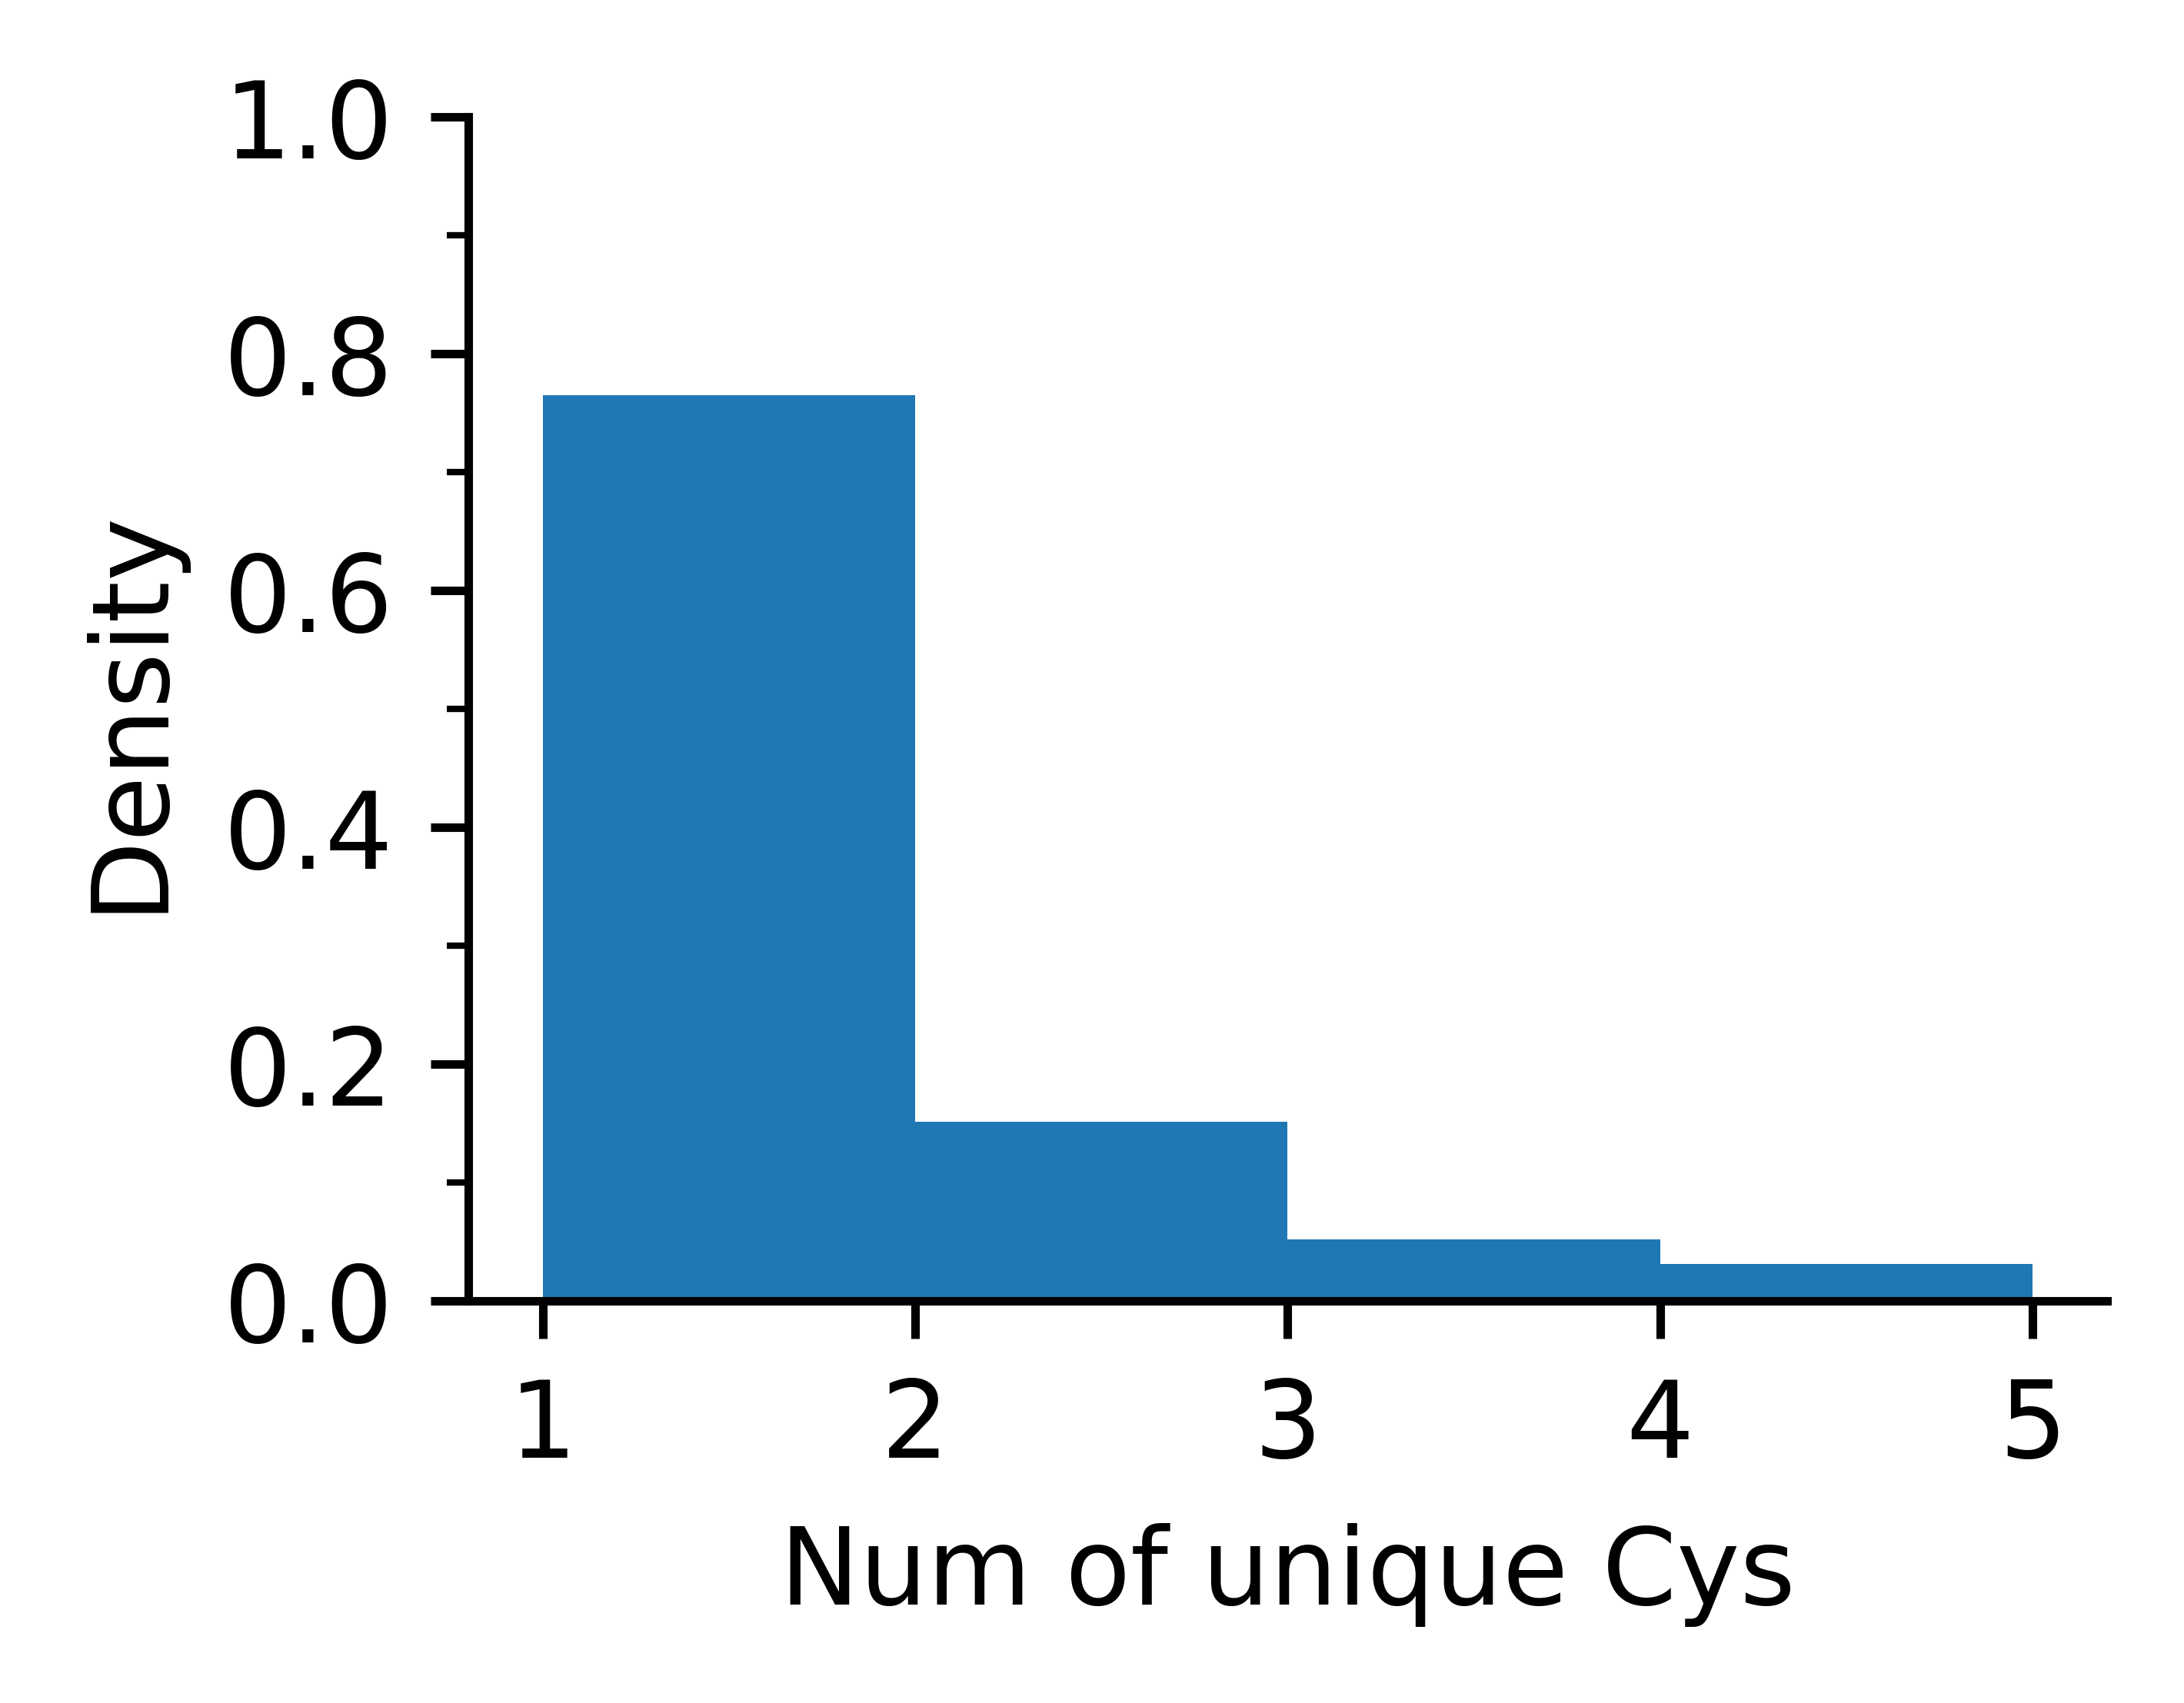

In [87]:
from matplotlib.ticker import MultipleLocator
n_unique = df_cov[df_cov.label].groupby('uniprot_id').uniprot_residue.nunique().to_dict()
with plt.style.context('default'):
    mpl.rcParams['text.color'] = 'black'
    mpl.rc('font', **font)
    fig, ax = plt.subplots(figsize=(2.75, 2.0), dpi=1000)
    plt.hist([i for i in n_unique.values()], bins=np.arange(1, 6), density=True)
    plt.xticks([1, 2, 3, 4, 5])
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.xlabel('Num of unique Cys')
    plt.ylabel('Density')
    ax.spines[['right', 'top']].set_visible(False)
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    plt.ylim([0, 1.0])
#     plt.title('ABPP')

In [13]:
sizes = df_backus_mul.groupby('uniprot_residue').size()
sizes = sizes[sizes > 1]
mul = df_backus_mul[df_backus_mul['uniprot_residue'].isin(sizes.index)]
print("Cys with multiple structures and combined:")
len(mul), len(df_backus_mul)

Cys with multiple structures and combined:


(1808, 2272)

In [14]:
len(set(mul.uniprot_residue)), len(set(mul[mul.label].uniprot_residue)), len(set(mul[~mul.label].uniprot_residue))

(165, 119, 46)

In [78]:
len(set(mul.uniprot_id)), len(set(mul[mul.label].uniprot_id)), len(set(mul[~mul.label].uniprot_id))

(104, 103, 27)

In [15]:
print("Number of structures when using a single structure for each:\nThey are also number of Cys.")
len(df_backus_single),\
len(df_backus_single[df_backus_single.label]),\
len(df_backus_single[~df_backus_single.label]),\

Number of structures when using a single structure for each:
They are also number of Cys.


(629, 190, 439)

In [16]:
print("Number of structures when using multiple structures for each:")
len(df_backus_mul),\
len(df_backus_mul[df_backus_mul.label]),\
len(df_backus_mul[~df_backus_mul.label])

Number of structures when using multiple structures for each:


(2272, 1602, 670)

In [17]:
print("Number of Cys when using multiple structures for each:")
len(set(df_backus_mul.uniprot_residue)),\
len(set(df_backus_mul[df_backus_mul.label].uniprot_residue)),\
len(set(df_backus_mul[~df_backus_mul.label].uniprot_residue))

Number of Cys when using multiple structures for each:


(629, 190, 439)

In [18]:
df_backus_mul.to_csv('abpp_mul_structs.csv', mode='w', index=False)

## 2. Predict using ETC

In [43]:
def evaluate_single_struct(model, dataset, probability_threshold=0.5):
    """Using a universal threshold. For ETC, we use 0.35
    """
    if isinstance(model, str):
        ml_model = load_model(model)
    else:
        ml_model = model
    if type(dataset) == pd.core.frame.DataFrame:
        test_df = dataset
    else:
        test_df = data_dict[dataset]
    
    # Get AUC using all data
    all_probs = ml_model.predict_proba(test_df)
    roc_auc = roc_auc_score(test_df['label'], all_probs[:, 1])
    y_preds = [True if i >= probability_threshold else False for i in all_probs[:, 1]]
    
    # Get other metrics
    recall = recall_score(test_df['label'], y_preds)
    precision = precision_score(test_df['label'], y_preds)
    selectivity = selectivity_score(test_df['label'], y_preds)
    npv = npv_score(test_df['label'], y_preds)
    acc = accuracy_score(test_df['label'], y_preds)
    f1 = f1_score(test_df['label'], y_preds) 
    
    return roc_auc, recall, precision, selectivity, npv, acc, f1

def evaluate_mul_struct(model, dataset, probability_threshold=0.5, vote_method='best'):
    """Using a universal threshold. For ETC, we use 0.35
    """
    if isinstance(model, str):
        ml_model = load_model(model)
    else:
        ml_model = model
    if type(dataset) == pd.core.frame.DataFrame:
        test_df = dataset
    else:
        test_df = data_dict[dataset]
    if vote_method not in ['best', 'major']:
        raise ValueError('"vote_method" has to be ether "best" or "major".')
    
    # Get AUC using all data
    all_probs = ml_model.predict_proba(test_df)
    roc_auc = roc_auc_score(test_df['label'], all_probs[:, 1])
    
    # Get predicted labels based on the highest Score_True among all structures of a Cys
    y_preds = []
    y_tests = []
    for i in set(test_df.uniprot_residue):
        resi = test_df[test_df.uniprot_residue == i]
        prob_i = ml_model.predict_proba(resi)
        true_i = resi['label'].tolist()[0]
        y_tests.append(true_i)
        predicts = []
        for j in prob_i[:, 1]:
            if j >= probability_threshold and vote_method == 'best':
                y_preds.append(True)
                break
            elif j >= probability_threshold and vote_method == 'major':
                predicts.append(True)
            elif vote_method == 'major':
                predicts.append(False)
        else:
            if vote_method == 'best':
                y_preds.append(False)
        if vote_method == 'major':
            if predicts.count(True) >= predicts.count(False):
                y_preds.append(True)
            else:
                y_preds.append(False)
    print(len(y_tests), len(y_preds))
    
    # Get metrics
    recall = recall_score(y_tests, y_preds)
    precision = precision_score(y_tests, y_preds)
    selectivity = selectivity_score(y_tests, y_preds)
    npv = npv_score(y_tests, y_preds)
    acc = accuracy_score(y_tests, y_preds)
    f1 = f1_score(y_tests, y_preds) 
    
    return roc_auc, recall, precision, selectivity, npv, acc, f1

### 2.1 When using multiple structures for each Cys

In [108]:
# Pure mul; using best vote
mul_results = {}
for j in range(6):
    pred = evaluate_mul_struct(f'covl_modi_10nonmodi_4neg_nodisulfide_et_F1_5000_trail{j}', mul, probability_threshold=0.35)
    mul_results[j] = pred
for k, v in mul_results.items():
    print(f'{k},{v[0]},{v[1]},{v[2]},{v[3]},{v[4]},{v[5]},{v[6]} ')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
0,0.6951616059912236,0.9159663865546218,0.8014705882352942,0.41304347826086957,0.6551724137931034,0.7757575757575758,0.8549019607843137 
1,0.6959586122658794,0.8739495798319328,0.8,0.43478260869565216,0.5714285714285714,0.7515151515151515,0.8353413654618475 
2,0.6925017744000641,0.8823529411764706,0.8015267175572519,0.43478260869565216,0.5882352941176471,0.7575757575757576,0.84 
3,0.7074303150061191,0.8907563025210085,0.803030303030303,0.43478260869565216,0.6060606060606061,0.7636363636363637,0.844621513944223 
4,0.685215533605133,0.8907563025210085,0.8091603053435115,0.45652173913043476,0.6176470588235294,0.7696969696969697,0.848 
5,0.696418423578181,0.88235294117647

In [76]:
# Pure mul; using major vote
mul_results = {}
for j in range(6):
    pred = evaluate_mul_struct(f'covl_modi_10nonmodi_4neg_nodisulfide_et_F1_5000_trail{j}', mul, probability_threshold=0.35, vote_method='major')
    mul_results[j] = pred
for k, v in mul_results.items():
    print(f'{k},{v[0]},{v[1]},{v[2]},{v[3]},{v[4]},{v[5]},{v[6]} ')

Transformation Pipeline and Model Successfully Loaded
165 165
Transformation Pipeline and Model Successfully Loaded
165 165
Transformation Pipeline and Model Successfully Loaded
165 165
Transformation Pipeline and Model Successfully Loaded
165 165
Transformation Pipeline and Model Successfully Loaded
165 165
Transformation Pipeline and Model Successfully Loaded
165 165
0,0.6951616059912236,0.8571428571428571,0.796875,0.43478260869565216,0.5405405405405406,0.7393939393939394,0.8259109311740891 
1,0.6959586122658794,0.7899159663865546,0.7966101694915254,0.4782608695652174,0.46808510638297873,0.703030303030303,0.7932489451476793 
2,0.6925017744000641,0.7983193277310925,0.7983193277310925,0.4782608695652174,0.4782608695652174,0.7090909090909091,0.7983193277310925 
3,0.7074303150061191,0.8319327731092437,0.8048780487804879,0.4782608695652174,0.5238095238095238,0.7333333333333333,0.8181818181818183 
4,0.685215533605133,0.8235294117647058,0.8099173553719008,0.5,0.5227272727272727,0.7333333333

In [77]:
mul.to_csv('abpp_puremul_structs.csv', mode='w', index=False)

In [35]:
# All mul + single; using best vote
backus_mul_results = {}
for j in range(6):
    pred = evaluate_mul_struct(f'covl_modi_10nonmodi_4neg_nodisulfide_et_F1_5000_trail{j}', df_backus_mul, probability_threshold=0.35)
    backus_mul_results[j] = pred
for k, v in backus_mul_results.items():
    print(f'{k},{v[0]},{v[1]},{v[2]},{v[3]},{v[4]},{v[5]},{v[6]} ')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
0,0.6634440158756778,0.868421052631579,0.4156171284634761,0.4715261958997722,0.8922413793103449,0.5914149443561209,0.5621805792163543 
1,0.6658160508319824,0.8315789473684211,0.4114583333333333,0.48519362186788156,0.8693877551020408,0.589825119236884,0.5505226480836236 
2,0.6681275271582165,0.8526315789473684,0.41968911917098445,0.489749430523918,0.8847736625514403,0.5993640699523053,0.5625 
3,0.6810069502673897,0.8473684210526315,0.4192708333333333,0.4920273348519362,0.8816326530612245,0.5993640699523053,0.5609756097560975 
4,0.6584167179085844,0.8368421052631579,0.4151436031331593,0.489749430523918,0.8739837398373984,0.5945945945945946,0.5549738219895287 
5,0.679111

In [44]:
# All mul + single; using major vote
backus_mul_major_results = {}
for j in range(6):
    pred = evaluate_mul_struct(f'covl_modi_10nonmodi_4neg_nodisulfide_et_F1_5000_trail{j}',
                               df_backus_mul, probability_threshold=0.35,
                               vote_method='major',
                              )
    backus_mul_major_results[j] = pred
for k, v in backus_mul_major_results.items():
    print(f'{k},{v[0]},{v[1]},{v[2]},{v[3]},{v[4]},{v[5]},{v[6]} ')

Transformation Pipeline and Model Successfully Loaded
629 629
Transformation Pipeline and Model Successfully Loaded
629 629
Transformation Pipeline and Model Successfully Loaded
629 629
Transformation Pipeline and Model Successfully Loaded
629 629
Transformation Pipeline and Model Successfully Loaded
629 629
Transformation Pipeline and Model Successfully Loaded
629 629
0,0.6634440158756778,0.8315789473684211,0.40616966580976865,0.47380410022779046,0.8666666666666667,0.5818759936406995,0.5457685664939551 
1,0.6658160508319824,0.7789473684210526,0.3978494623655914,0.489749430523918,0.8365758754863813,0.5771065182829889,0.5266903914590747 
2,0.6681275271582165,0.8,0.40641711229946526,0.49430523917995445,0.8509803921568627,0.5866454689984102,0.5390070921985816 
3,0.6810069502673897,0.8105263157894737,0.4106666666666667,0.49658314350797267,0.8582677165354331,0.5914149443561209,0.5451327433628319 
4,0.6584167179085844,0.7947368421052632,0.40482573726541554,0.49430523917995445,0.84765625,0.58

### 2.1 When using a single structure for each Cys


In [79]:
# single in pure mul
single = df_backus_single[df_backus_single.uniprot_residue.isin(mul.uniprot_residue)]
single_results = {}
for j in range(6):
    pred = evaluate_single_struct(f'covl_modi_10nonmodi_4neg_nodisulfide_et_F1_5000_trail{j}', single, probability_threshold=0.35)
    single_results[j] = pred
for k, v in single_results.items():
    print(f'{k},{v[0]},{v[1]},{v[2]},{v[3]},{v[4]},{v[5]},{v[6]} ')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
0,0.6919985385458531,0.8571428571428571,0.796875,0.43478260869565216,0.5405405405405406,0.7393939393939394,0.8259109311740891 
1,0.7095359883083668,0.8151260504201681,0.7950819672131147,0.45652173913043476,0.4883720930232558,0.7151515151515152,0.8049792531120331 
2,0.7029594446474242,0.8067226890756303,0.8067226890756303,0.5,0.5,0.7212121212121212,0.8067226890756303 
3,0.7199488491048593,0.8235294117647058,0.7967479674796748,0.45652173913043476,0.5,0.7212121212121212,0.8099173553719009 
4,0.711728169528681,0.8067226890756303,0.8,0.4782608695652174,0.4888888888888889,0.7151515151515152,0.803347280334728 
5,0.7100840336134453,0.8067226890756303,0.7933884297520661,0.4565

In [80]:
single.to_csv('abpp_singleinpure.csv', mode='w', index=False)

In [31]:
# All single
backus_single_results = {}
for j in range(6):
    pred = evaluate_single_struct(f'covl_modi_10nonmodi_4neg_nodisulfide_et_F1_5000_trail{j}', df_backus_single, probability_threshold=0.35)
    backus_single_results[j] = pred
for k, v in backus_single_results.items():
    print(f'{k},{v[0]},{v[1]},{v[2]},{v[3]},{v[4]},{v[5]},{v[6]} ')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
0,0.6787675338688407,0.8315789473684211,0.40616966580976865,0.47380410022779046,0.8666666666666667,0.5818759936406995,0.5457685664939551 
1,0.6849298645246373,0.7947368421052632,0.4015957446808511,0.4874715261958998,0.8458498023715415,0.5802861685214626,0.5335689045936395 
2,0.6886704232106461,0.8052631578947368,0.4090909090909091,0.49658314350797267,0.8549019607843137,0.589825119236884,0.5425531914893618 
3,0.7008152499700276,0.8052631578947368,0.408,0.49430523917995445,0.8543307086614174,0.5882352941176471,0.5415929203539822 
4,0.6895815849418534,0.7842105263157895,0.40053763440860213,0.4920273348519362,0.8404669260700389,0.5802861685214626,0.5302491103202848 
5,0.6

In [32]:
backus_af2_results = {}
for j in range(6):
    pred = evaluate_single_struct(f'covl_modi_10nonmodi_4neg_nodisulfide_et_F1_5000_trail{j}', df_backus_af2, probability_threshold=0.35)
    backus_af2_results[j] = pred
for k, v in backus_af2_results.items():
    print(f'{k},{v[0]},{v[1]},{v[2]},{v[3]},{v[4]},{v[5]},{v[6]} ')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
0,0.6905886584342406,0.8421052631578947,0.4050632911392405,0.4646924829157175,0.8717948717948718,0.5786963434022258,0.547008547008547 
1,0.7004915477760462,0.8368421052631579,0.40458015267175573,0.46697038724373574,0.8686440677966102,0.5786963434022258,0.5454545454545454 
2,0.6986212684330415,0.8210526315789474,0.40102827763496146,0.46924829157175396,0.8583333333333333,0.575516693163752,0.538860103626943 
3,0.7003476801342765,0.8210526315789474,0.4,0.46697038724373574,0.8577405857740585,0.5739268680445151,0.5379310344827586 
4,0.6844263277784439,0.8421052631578947,0.40404040404040403,0.4624145785876993,0.871244635193133,0.5771065182829889,0.5460750853242321 
5,0.69833

## 3. Examples for pos and neg Cys with multiple structures

In [45]:
def evaluate_mul_struct_prob(model, dataset):
    """Using a universal threshold. For ETC, we use 0.35
    """
    if isinstance(model, str):
        ml_model = load_model(model)
    else:
        ml_model = model
    if type(dataset) == pd.core.frame.DataFrame:
        test_df = dataset
    else:
        test_df = data_dict[dataset]
    
    # Get list of Score_True for each Cys
    y_probs = {}
    for i in set(test_df.uniprot_residue):
        resi = test_df[test_df.uniprot_residue == i]
        prob_i = ml_model.predict_proba(resi)
        y_probs[i] = prob_i[:, 1].tolist()
    
    return y_probs

In [46]:
# Find number of structures for each Cys

num_of_strucs_pos = defaultdict(int)
for _,r in df_backus_mul[df_backus_mul.label].iterrows():
    acc = r['uniprot_residue']
    num_of_strucs_pos[acc] += 1
num_of_strucs_pos = dict(sorted(num_of_strucs_pos.items(), key=lambda item: item[1], reverse=True))
# 'P15121_C299': 154, 'P09211_C48': 139, 'O75874_C269': 110

num_of_strucs_neg = defaultdict(int)
for _,r in df_backus_mul[~df_backus_mul.label].iterrows():
    acc = r['uniprot_residue']
    num_of_strucs_neg[acc] += 1
num_of_strucs_neg = dict(sorted(num_of_strucs_neg.items(), key=lambda item: item[1], reverse=True))

In [47]:
# For positive and negative classes, we select those Cys with more than 20 and 5 structures respectively

pos_g20 = [k for k,v in num_of_strucs_pos.items() if v >=20]
neg_g5 = [k for k,v in num_of_strucs_neg.items() if v >=5]

In [48]:
# Compare the positives

df_pos_mul_g20 = df_backus_mul[df_backus_mul.uniprot_residue.isin(pos_g20)]
pos_mul_g20_probs = {}
for j in range(6):
    prob = evaluate_mul_struct_prob(f'covl_modi_10nonmodi_4neg_nodisulfide_et_F1_5000_trail{j}', df_pos_mul_g20)
    pos_mul_g20_probs[j] = prob
    
df_pos_single_g20 = df_backus_pdb_unique[df_backus_pdb_unique.uniprot_residue.isin(pos_g20)]
pos_single_g20_probs = {}
for j in range(6):
    prob = evaluate_mul_struct_prob(f'covl_modi_10nonmodi_4neg_nodisulfide_et_F1_5000_trail{j}', df_pos_single_g20)
    pos_single_g20_probs[j] = prob

df_pos_af2_g20 = df_backus_af2[df_backus_af2.uniprot_residue.isin(pos_g20)]
pos_af2_g20_probs = {}
for j in range(6):
    prob = evaluate_mul_struct_prob(f'covl_modi_10nonmodi_4neg_nodisulfide_et_F1_5000_trail{j}', df_pos_af2_g20)
    pos_af2_g20_probs[j] = prob


Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [50]:
# Compare the negatives

df_neg_mul_g5 = df_backus_mul[df_backus_mul.uniprot_residue.isin(neg_g5)]
neg_mul_g5_probs = {}
for j in range(6):
    prob = evaluate_mul_struct_prob(f'covl_modi_10nonmodi_4neg_nodisulfide_et_F1_5000_trail{j}', df_neg_mul_g5)
    neg_mul_g5_probs[j] = prob
    
df_neg_single_g5 = df_backus_pdb_unique[df_backus_pdb_unique.uniprot_residue.isin(neg_g5)]
neg_single_g5_probs = {}
for j in range(6):
    prob = evaluate_mul_struct_prob(f'covl_modi_10nonmodi_4neg_nodisulfide_et_F1_5000_trail{j}', df_neg_single_g5)
    neg_single_g5_probs[j] = prob

df_neg_af2_g5 = df_backus_af2[df_backus_af2.uniprot_residue.isin(neg_g5)]
neg_af2_g5_probs = {}
for j in range(6):
    prob = evaluate_mul_struct_prob(f'covl_modi_10nonmodi_4neg_nodisulfide_et_F1_5000_trail{j}', df_neg_af2_g5)
    neg_af2_g5_probs[j] = prob


Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [51]:
# Avearge over models

# Multi
res_scores = defaultdict(list)
for model, probs in pos_mul_g20_probs.items():
    for res, scores in probs.items():
        res_scores[res].append(scores)
pos_mul_g20_mean = defaultdict(list)
pos_mul_g20_std = defaultdict(list)
for res, scores in res_scores.items():
    scores = np.array(scores)
    pos_mul_g20_mean[res] = np.mean(scores, axis=0)
    pos_mul_g20_std[res] = np.std(scores, axis=0)

# Single  
res_scores = defaultdict(list)
for model, probs in pos_single_g20_probs.items():
    for res, scores in probs.items():
        res_scores[res].append(scores)
pos_single_g20_mean = defaultdict(list)
pos_single_g20_std = defaultdict(list)
for res, scores in res_scores.items():
    scores = np.array(scores)
    pos_single_g20_mean[res] = np.mean(scores, axis=0)
    pos_single_g20_std[res] = np.std(scores, axis=0)

# AF2
res_scores = defaultdict(list)
for model, probs in pos_af2_g20_probs.items():
    for res, scores in probs.items():
        res_scores[res].append(scores)
pos_af2_g20_mean = defaultdict(list)
pos_af2_g20_std = defaultdict(list)
for res, scores in res_scores.items():
    scores = np.array(scores)
    pos_af2_g20_mean[res] = np.mean(scores, axis=0)
    pos_af2_g20_std[res] = np.std(scores, axis=0)

In [52]:
len(pos_mul_g20_mean), len(pos_single_g20_mean), len(pos_af2_g20_mean)

(19, 19, 19)

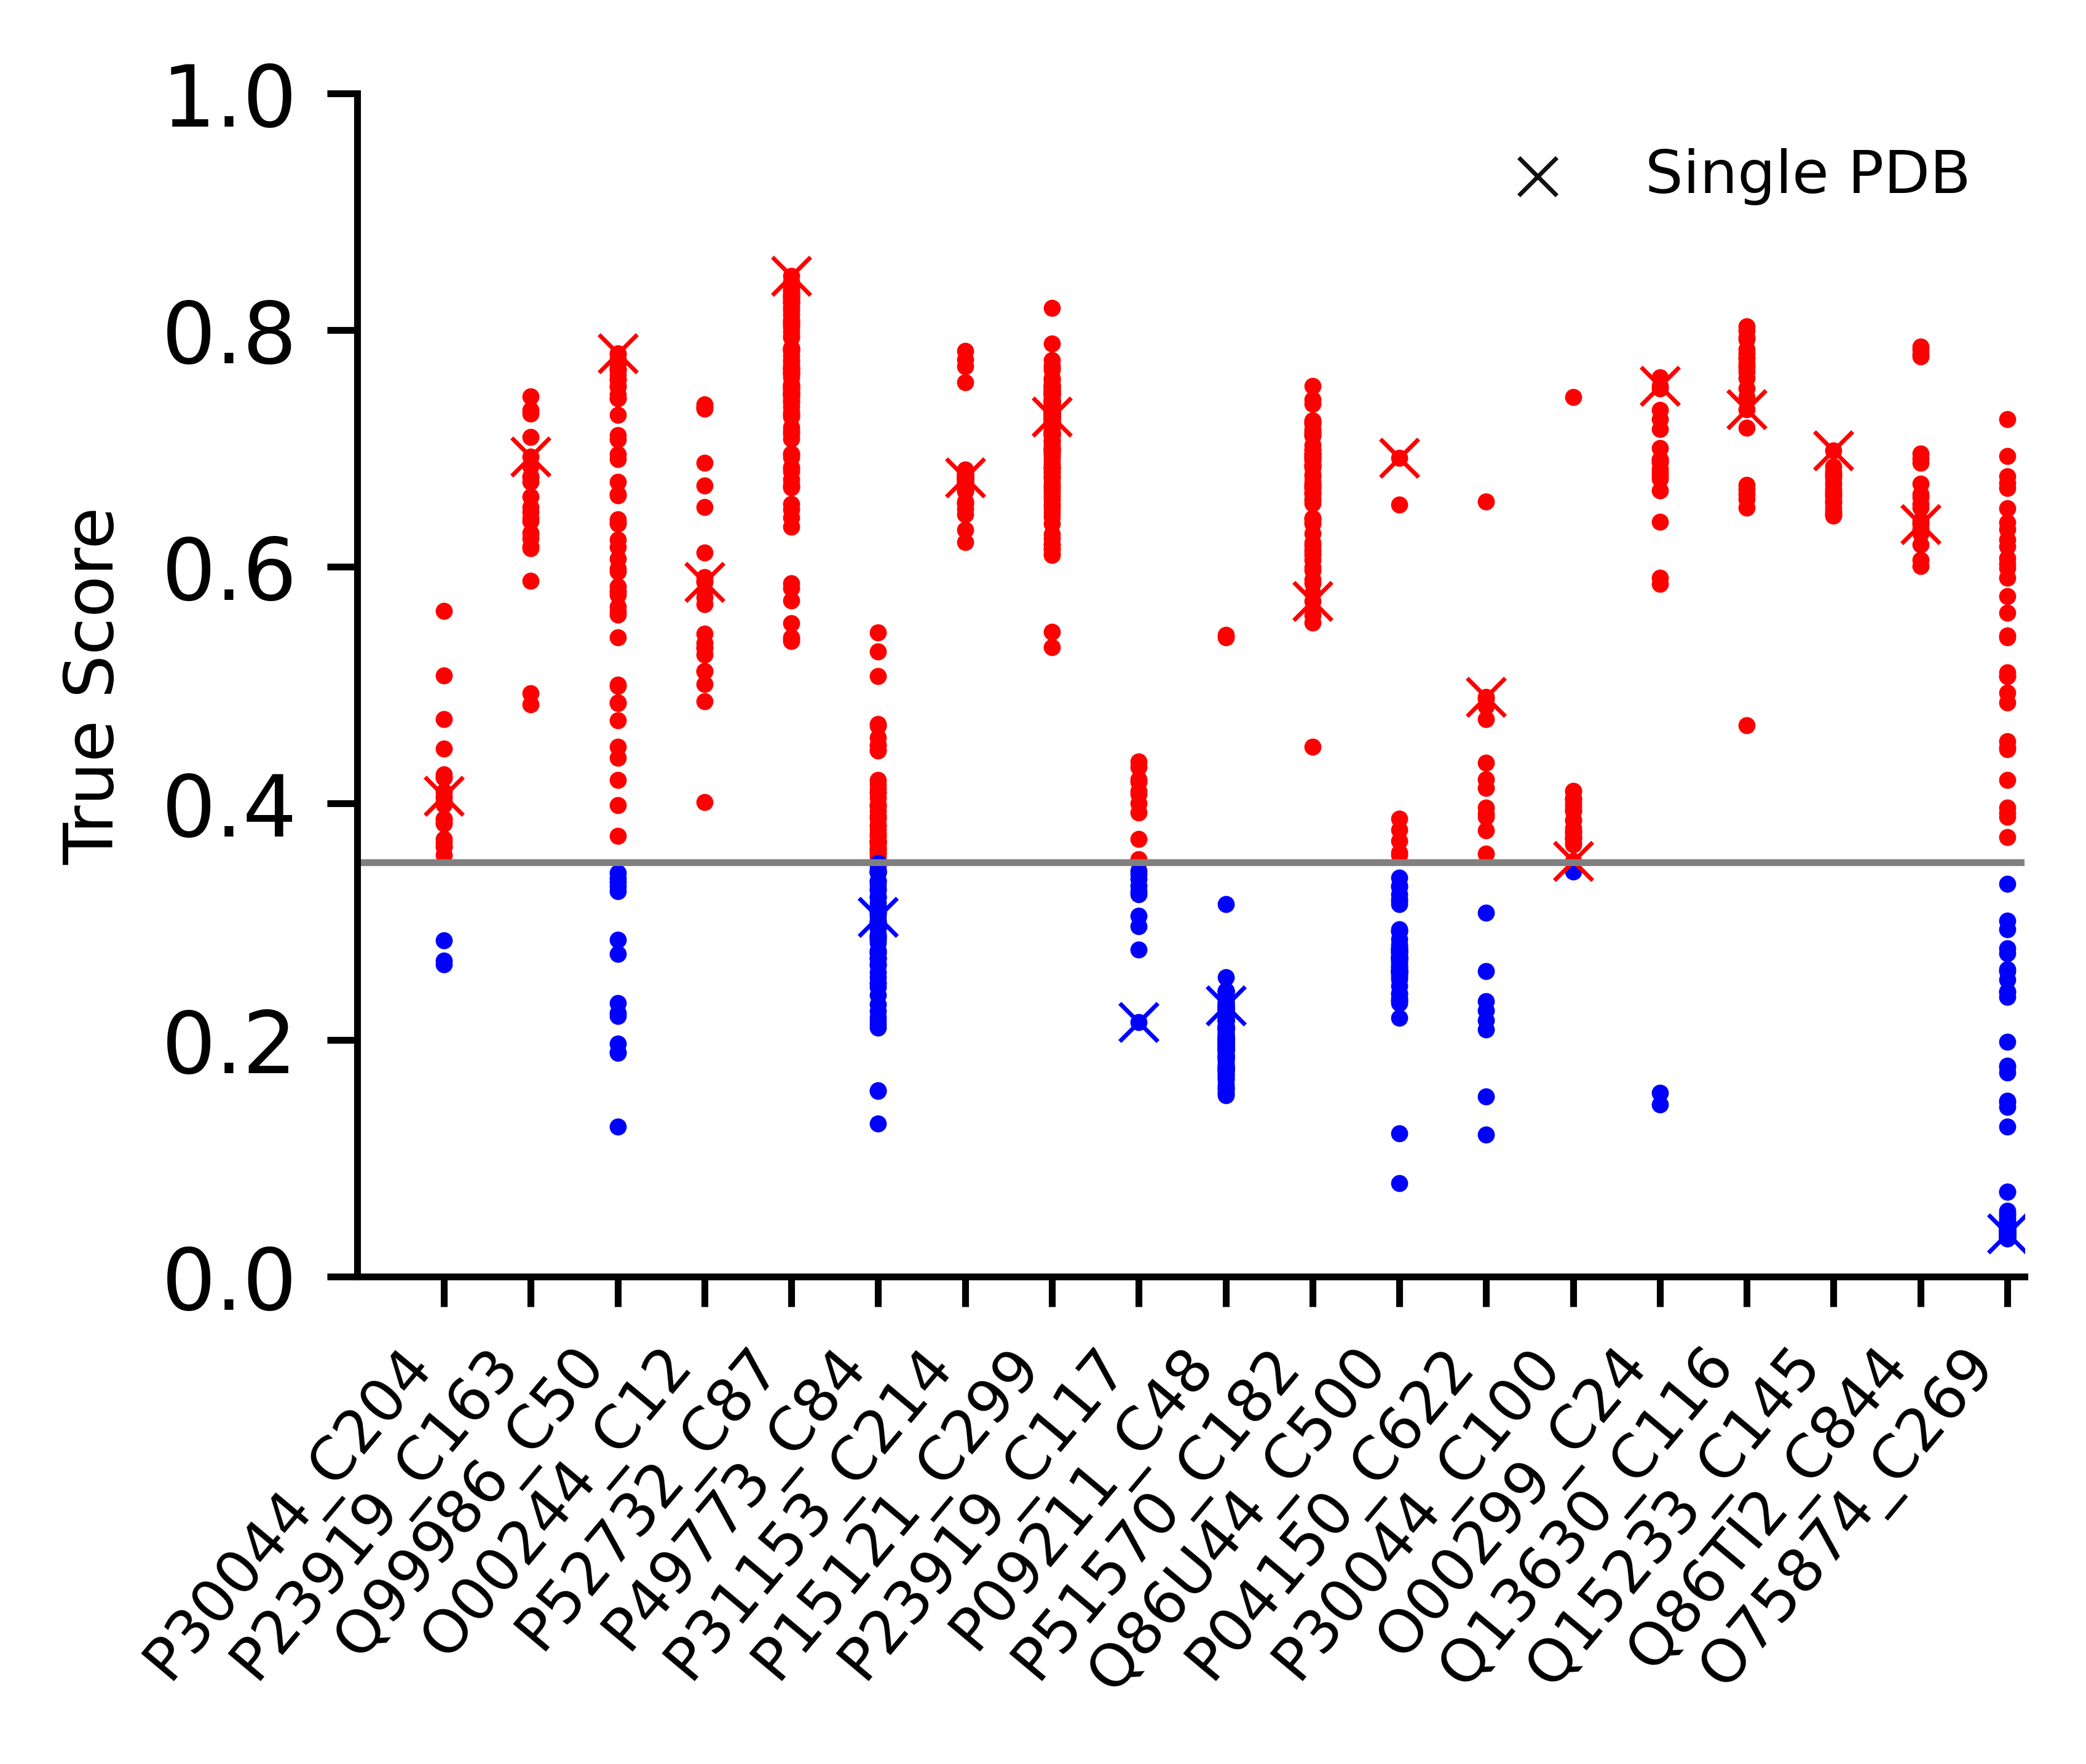

In [75]:
threshold = 0.35
with plt.style.context('default'):
    mpl.rcParams['text.color'] = 'black'
    mpl.rc('font', **font)
    fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=1000)
    for i, (residue, scores) in enumerate(pos_mul_g20_mean.items()):
        pos = [j for j in scores if j >= threshold]
        neg = [j for j in scores if j < threshold]
        af2 = pos_af2_g20_mean[residue]
        unique = pos_single_g20_mean[residue]
        x_p = [i for _ in range(len(pos))]
        x_n = [i for _ in range(len(neg))]
        x_af2 = [i]
        x_unique = [i]
        if af2 >= threshold:
            af2_color = 'magenta'
        else:
            af2_color = 'cyan'
        if unique >= threshold:
            unique_color = 'red'
        else:
            unique_color = 'blue'
        if i == 0:
            plt.scatter(x_p, pos, color='red', s=1, facecolor='white')
            plt.scatter(x_n, neg, color='blue', s=1, label=' ', facecolor='white')
            plt.scatter(x_unique, unique, marker='x', s=20, c=unique_color, label='Single PDB', facecolor='white', linewidths=0.5)
#             plt.scatter(x_af2, af2, marker='*', s=8, c=af2_color, label='AF2', facecolor='white')
        else:
            plt.scatter(x_p, pos, color='red', s=1, facecolor='k')
            plt.scatter(x_n, neg, color='blue', s=1, facecolor='k')
            plt.scatter(x_unique, unique, marker='x', s=20, c=unique_color, facecolor='k', linewidths=0.5)
#             plt.scatter(x_af2, af2, marker='*', s=8, c=af2_color, facecolor='k')
    plt.legend(ncol=3, frameon=False, fontsize=7)
    line_x = [-1] + [j for j in range(i)] + [i+1]
    plt.plot(line_x, [0.35 for _ in range(len(line_x))], color='grey', ls='-', lw=0.8)
    ax.set_ylabel('True Score', fontsize=8)
    plt.xticks([i for i in range(len(pos_mul_g20_mean))],
               [k for k in pos_mul_g20_mean.keys()],
               rotation=50,
               ha='right',
               fontsize=7,
              )
    plt.ylim([0.0, 1.0])
    plt.xlim([-1, len(line_x)-1.8])
    ax.spines[['right', 'top']].set_visible(False)
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('white')
    leg.legendHandles[1].set_color('k')
#     plt.gca().lines[0].set_linewidth(5)
#     leg.legendHandles[2].set_color('k')
    plt.show()
    plt.close()
#     break

### Look into the O75874_C269 case

In [216]:
used_in_unique = df_backus_pdb_unique[df_backus_pdb_unique.uniprot_residue == 'O75874_C269']

In [177]:
O75874_C269 = df_pos_mul_g20[df_pos_mul_g20.uniprot_residue == 'O75874_C269']
O75874_C269.to_csv('O75874_C269.csv')
O75874_C269.head()

,pdb,chain,resid,in_dataset,uniprot_id,uniprot_resid,in_seq,assb_type,cov_modified,label,all_atoms,total_side,main_chain,non_polar,all_polar,flex_bvalue,flex_rmsf,pa_1,pa_2,npa_1,npa_2,bb_nh_1,bb_nh_2,neg_o_1,neg_o_2,pos_n_1,pos_n_2,hb_o_1,hb_o_2,hb_n_1,hb_n_2,hb_h_1,hb_h_2,n_ca_6,n_ca_9,n_ca_12,n_ca_15,n_hv_6,n_hv_9,n_hv_12,n_hv_15,d_interface,n_dssp,n2_dssp,n4_dssp,sg_pocket_d1,sg_pocket_d2,ca_pocket_d1,ca_pocket_d2,has_drug_like_comp,largest_comp_weight,uniprot_residue
898,8BAY,A,269,abpp,O75874,269,both,dimeric,False,True,0.00,0.00,0.00,0.00,0.00,-0.105,-0.067,6.922503,7.711595,3.465165,3.480456,4.254291,4.737079,6.034442,6.467410,10.007689,10.300408,3.952953,8.075443,3.201923,6.971398,10.425212,11.176351,7,18,45,89,48,149,377,718,8.532692,B,H,H,6.34,7.32,6.71,7.093014,True,745.421,O75874_C269
899,8BAY,B,269,abpp,O75874,269,both,dimeric,False,True,0.00,0.00,0.00,0.00,0.00,-0.105,-0.067,6.997832,7.795122,3.376972,3.558542,4.307308,4.718784,6.015171,6.637793,9.981107,10.209035,4.000367,7.788952,3.260088,6.775289,10.530429,11.283924,7,18,44,88,46,147,374,713,8.617576,B,H,H,6.27,7.83,6.80,7.056836,True,745.421,O75874_C269
942,6B0Z,D,269,abpp,O75874,269,both,dimeric,False,True,11.80,11.80,0.00,11.80,0.00,-0.105,-0.067,7.671174,9.510620,3.351296,3.531691,4.721638,5.031606,8.598183,9.361145,9.355765,10.956956,4.303632,6.801599,3.222159,4.424373,4.424373,4.548405,5,15,42,78,45,136,333,636,10.370908,B,L,L,3.04,6.59,3.93,7.575296,True,745.421,O75874_C269
943,6B0Z,C,269,abpp,O75874,269,both,dimeric,False,True,2.57,2.57,0.00,2.57,0.00,-0.105,-0.067,6.316855,7.883252,3.430025,3.473522,4.984006,4.985558,9.053723,9.203837,9.712460,9.834487,4.182265,5.704377,3.211228,5.537822,7.926661,8.094894,7,14,44,83,45,145,354,652,8.738307,B,L,L,3.03,9.81,3.23,8.791097,True,745.421,O75874_C269
944,6B0Z,B,269,abpp,O75874,269,both,dimeric,False,True,2.89,2.25,0.65,2.25,0.65,-0.105,-0.067,6.373745,7.825893,3.426749,3.457889,4.882808,5.064099,9.360243,9.878053,9.828062,10.178143,4.183270,5.531763,3.238734,5.735988,7.873574,8.000600,7,14,42,81,48,137,349,658,10.372253,B,L,L,3.12,6.96,3.03,9.641776,True,745.421,O75874_C269


In [190]:
O75874_132 = pd.read_csv('O75874_C269/O75874_132.csv')
set(O75874_132['132'])

{'ARG', 'CYS', 'HIS'}

In [182]:
O75874 = O75874_C269.merge(O75874_132, on=['pdb', 'chain'], how='inner')

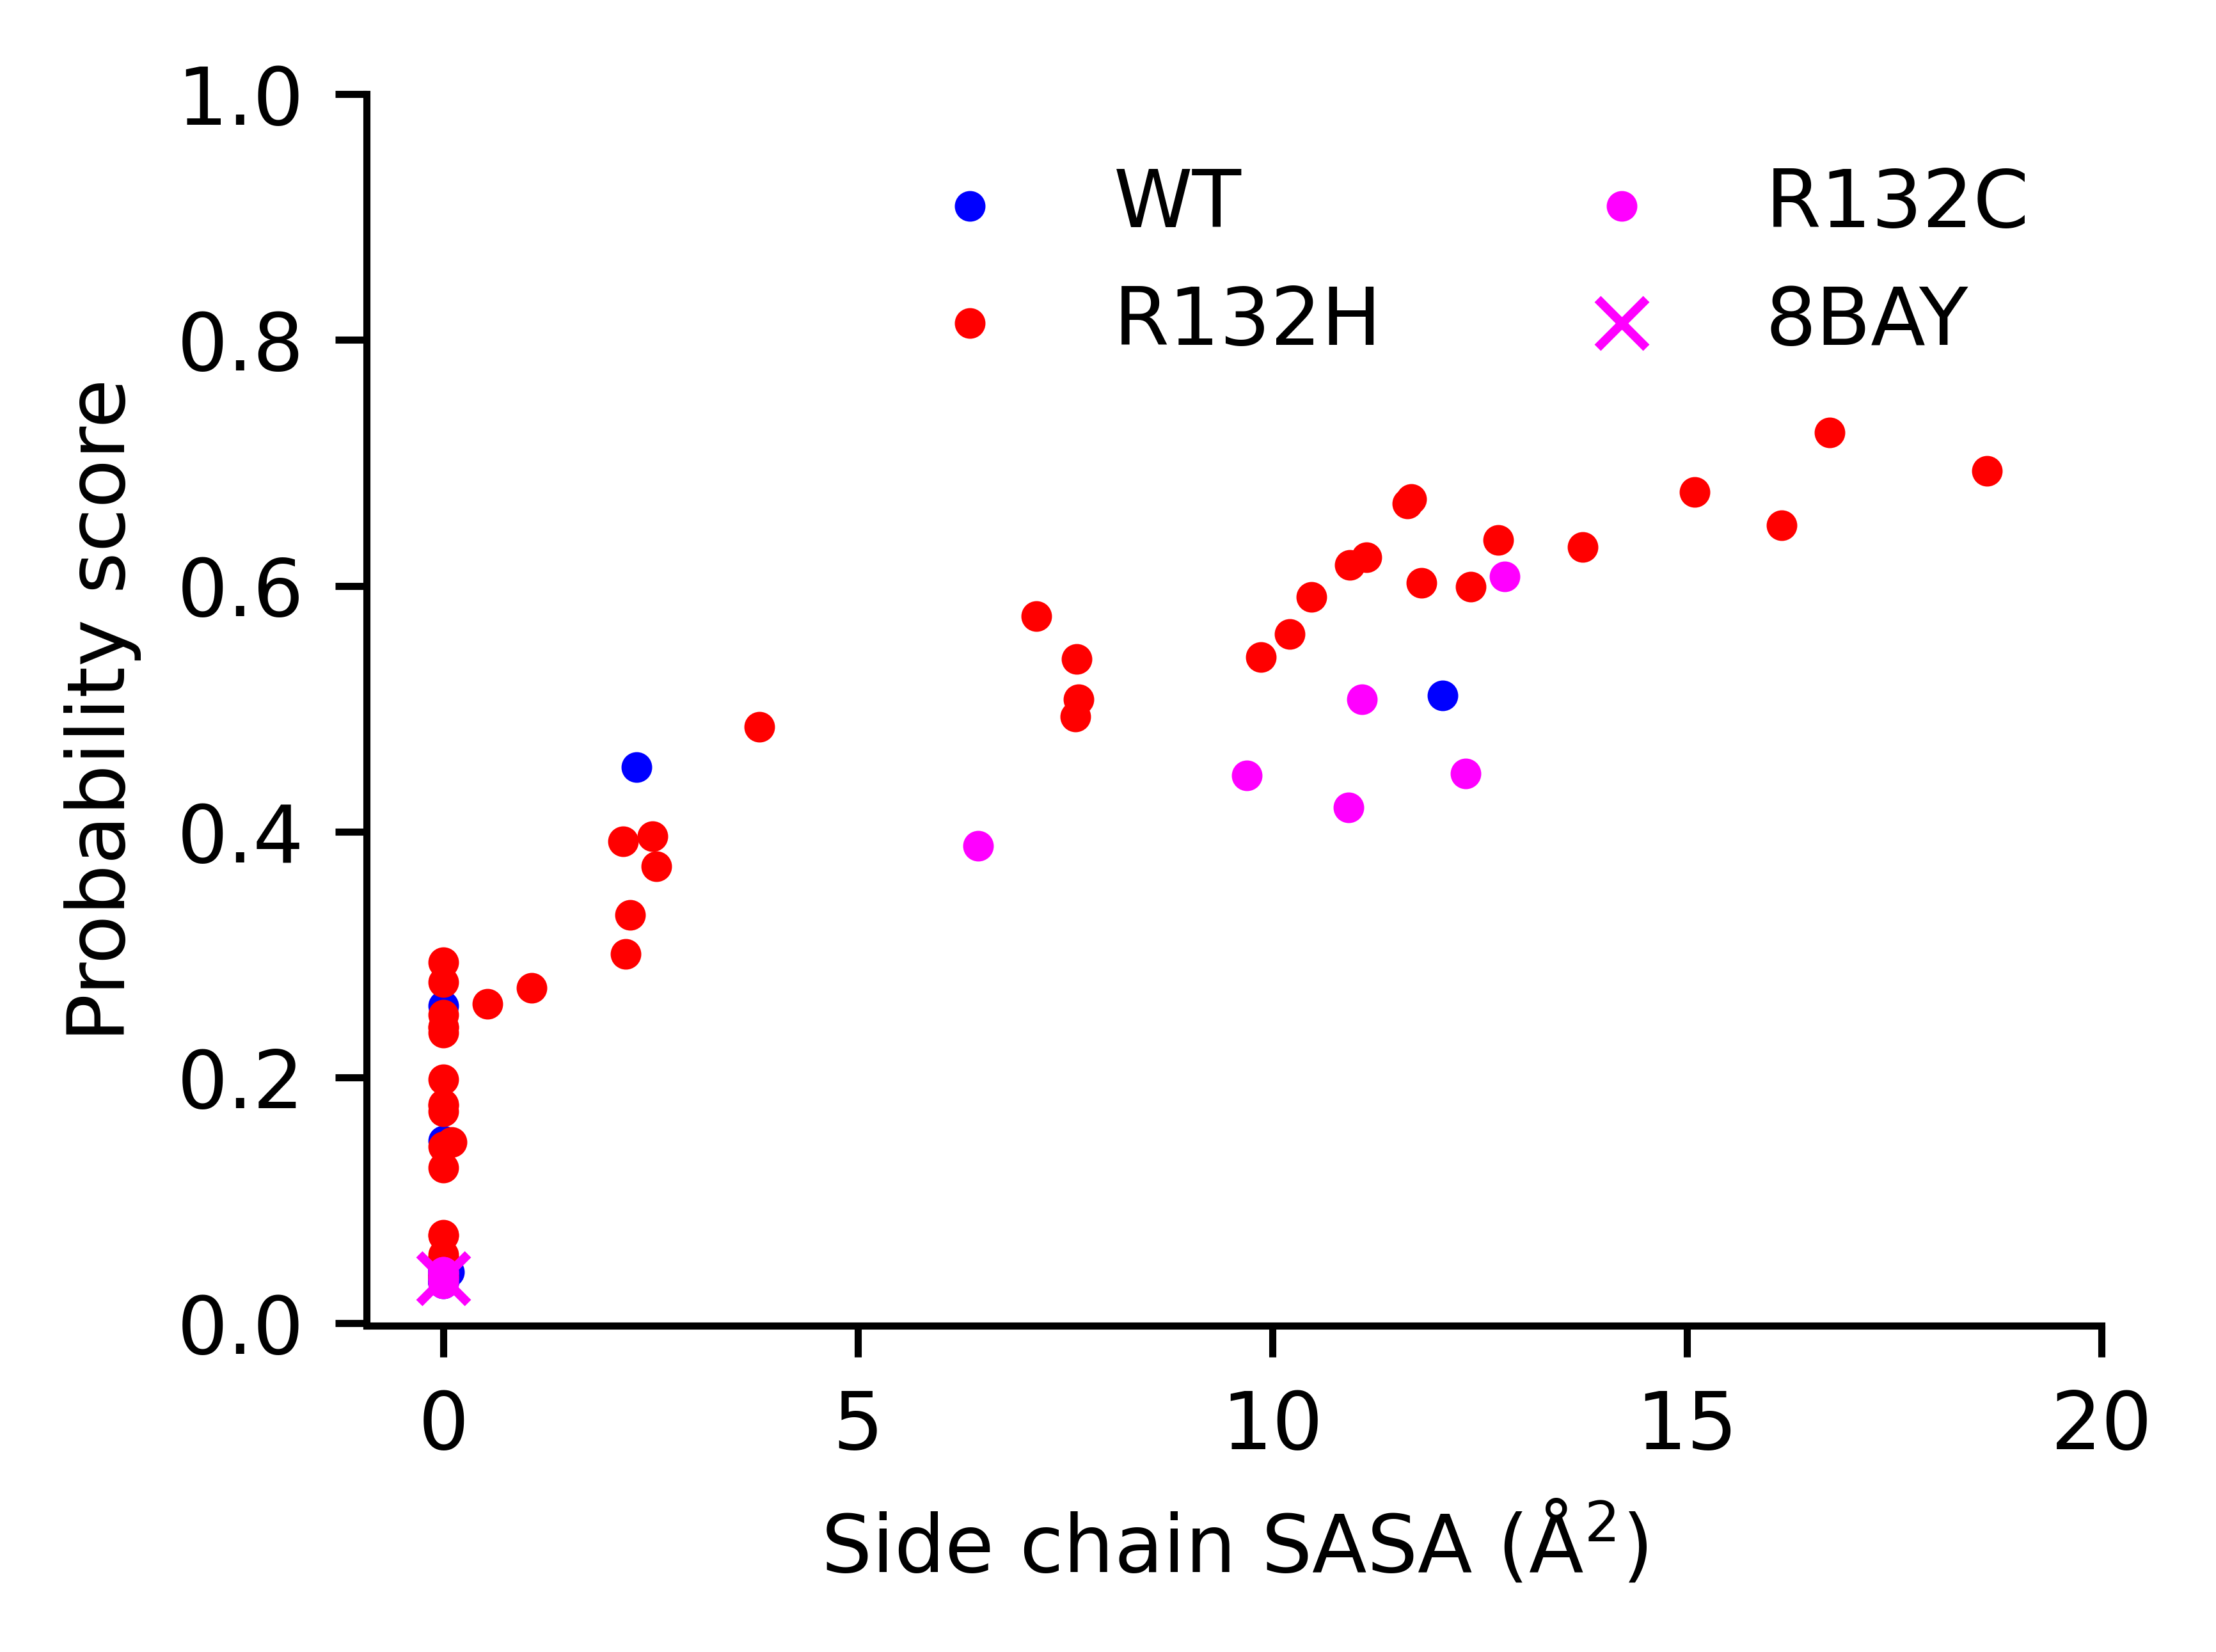

In [250]:
with plt.style.context('default'):
    mpl.rcParams['text.color'] = 'black'
    mpl.rc('font', **font)
    fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=1000)
    
    r132_indices = O75874[O75874['132'] == 'ARG'].index
    r132 = O75874.iloc[r132_indices]
    r132_score = pos_mul_g20_mean['O75874_C269'][r132_indices]
    plt.scatter(r132.total_side, r132_score, s=6, c='blue', marker='o', label='WT')
    
    h132_indices = O75874[O75874['132'] == 'HIS'].index
    h132 = O75874.iloc[h132_indices]
    h132_score = pos_mul_g20_mean['O75874_C269'][h132_indices]
    plt.scatter(h132.total_side, h132_score, s=6, c='red', marker='o', label='R132H')
    
    c132_indices = O75874[O75874['132'] == 'CYS'].index
    c132 = O75874.iloc[c132_indices]
    c132_score = pos_mul_g20_mean['O75874_C269'][c132_indices]
    plt.scatter(c132.total_side, c132_score, s=6, c='magenta', marker='o', label='R132C')
    
    unique_index = O75874[(O75874.pdb == '8BAY') & (O75874.chain == 'C')].index
    unique = O75874.iloc[unique_index]
    unique_score = pos_mul_g20_mean['O75874_C269'][unique_index]
    plt.scatter(unique.total_side, unique_score, s=30, c='magenta', marker='x', linewidths=1, label='8BAY')
    
#     plt.scatter(O75874.total_side, pos_mul_g20_mean['O75874_C269'], s=6, c='k')
    ax.set_xlabel(r'Side chain SASA (Å$^2$)', fontsize=9)
    ax.set_ylabel('Probability score', fontsize=9)
    ax.set_xticks([0, 5, 10, 15, 20], fontsize=9)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=9)
    ax.spines[['right', 'top']].set_visible(False)
    plt.legend(ncol=2, frameon=False, fontsize=9)
    plt.show()
    plt.savefig('O75874_C269.pdf')
    plt.close()


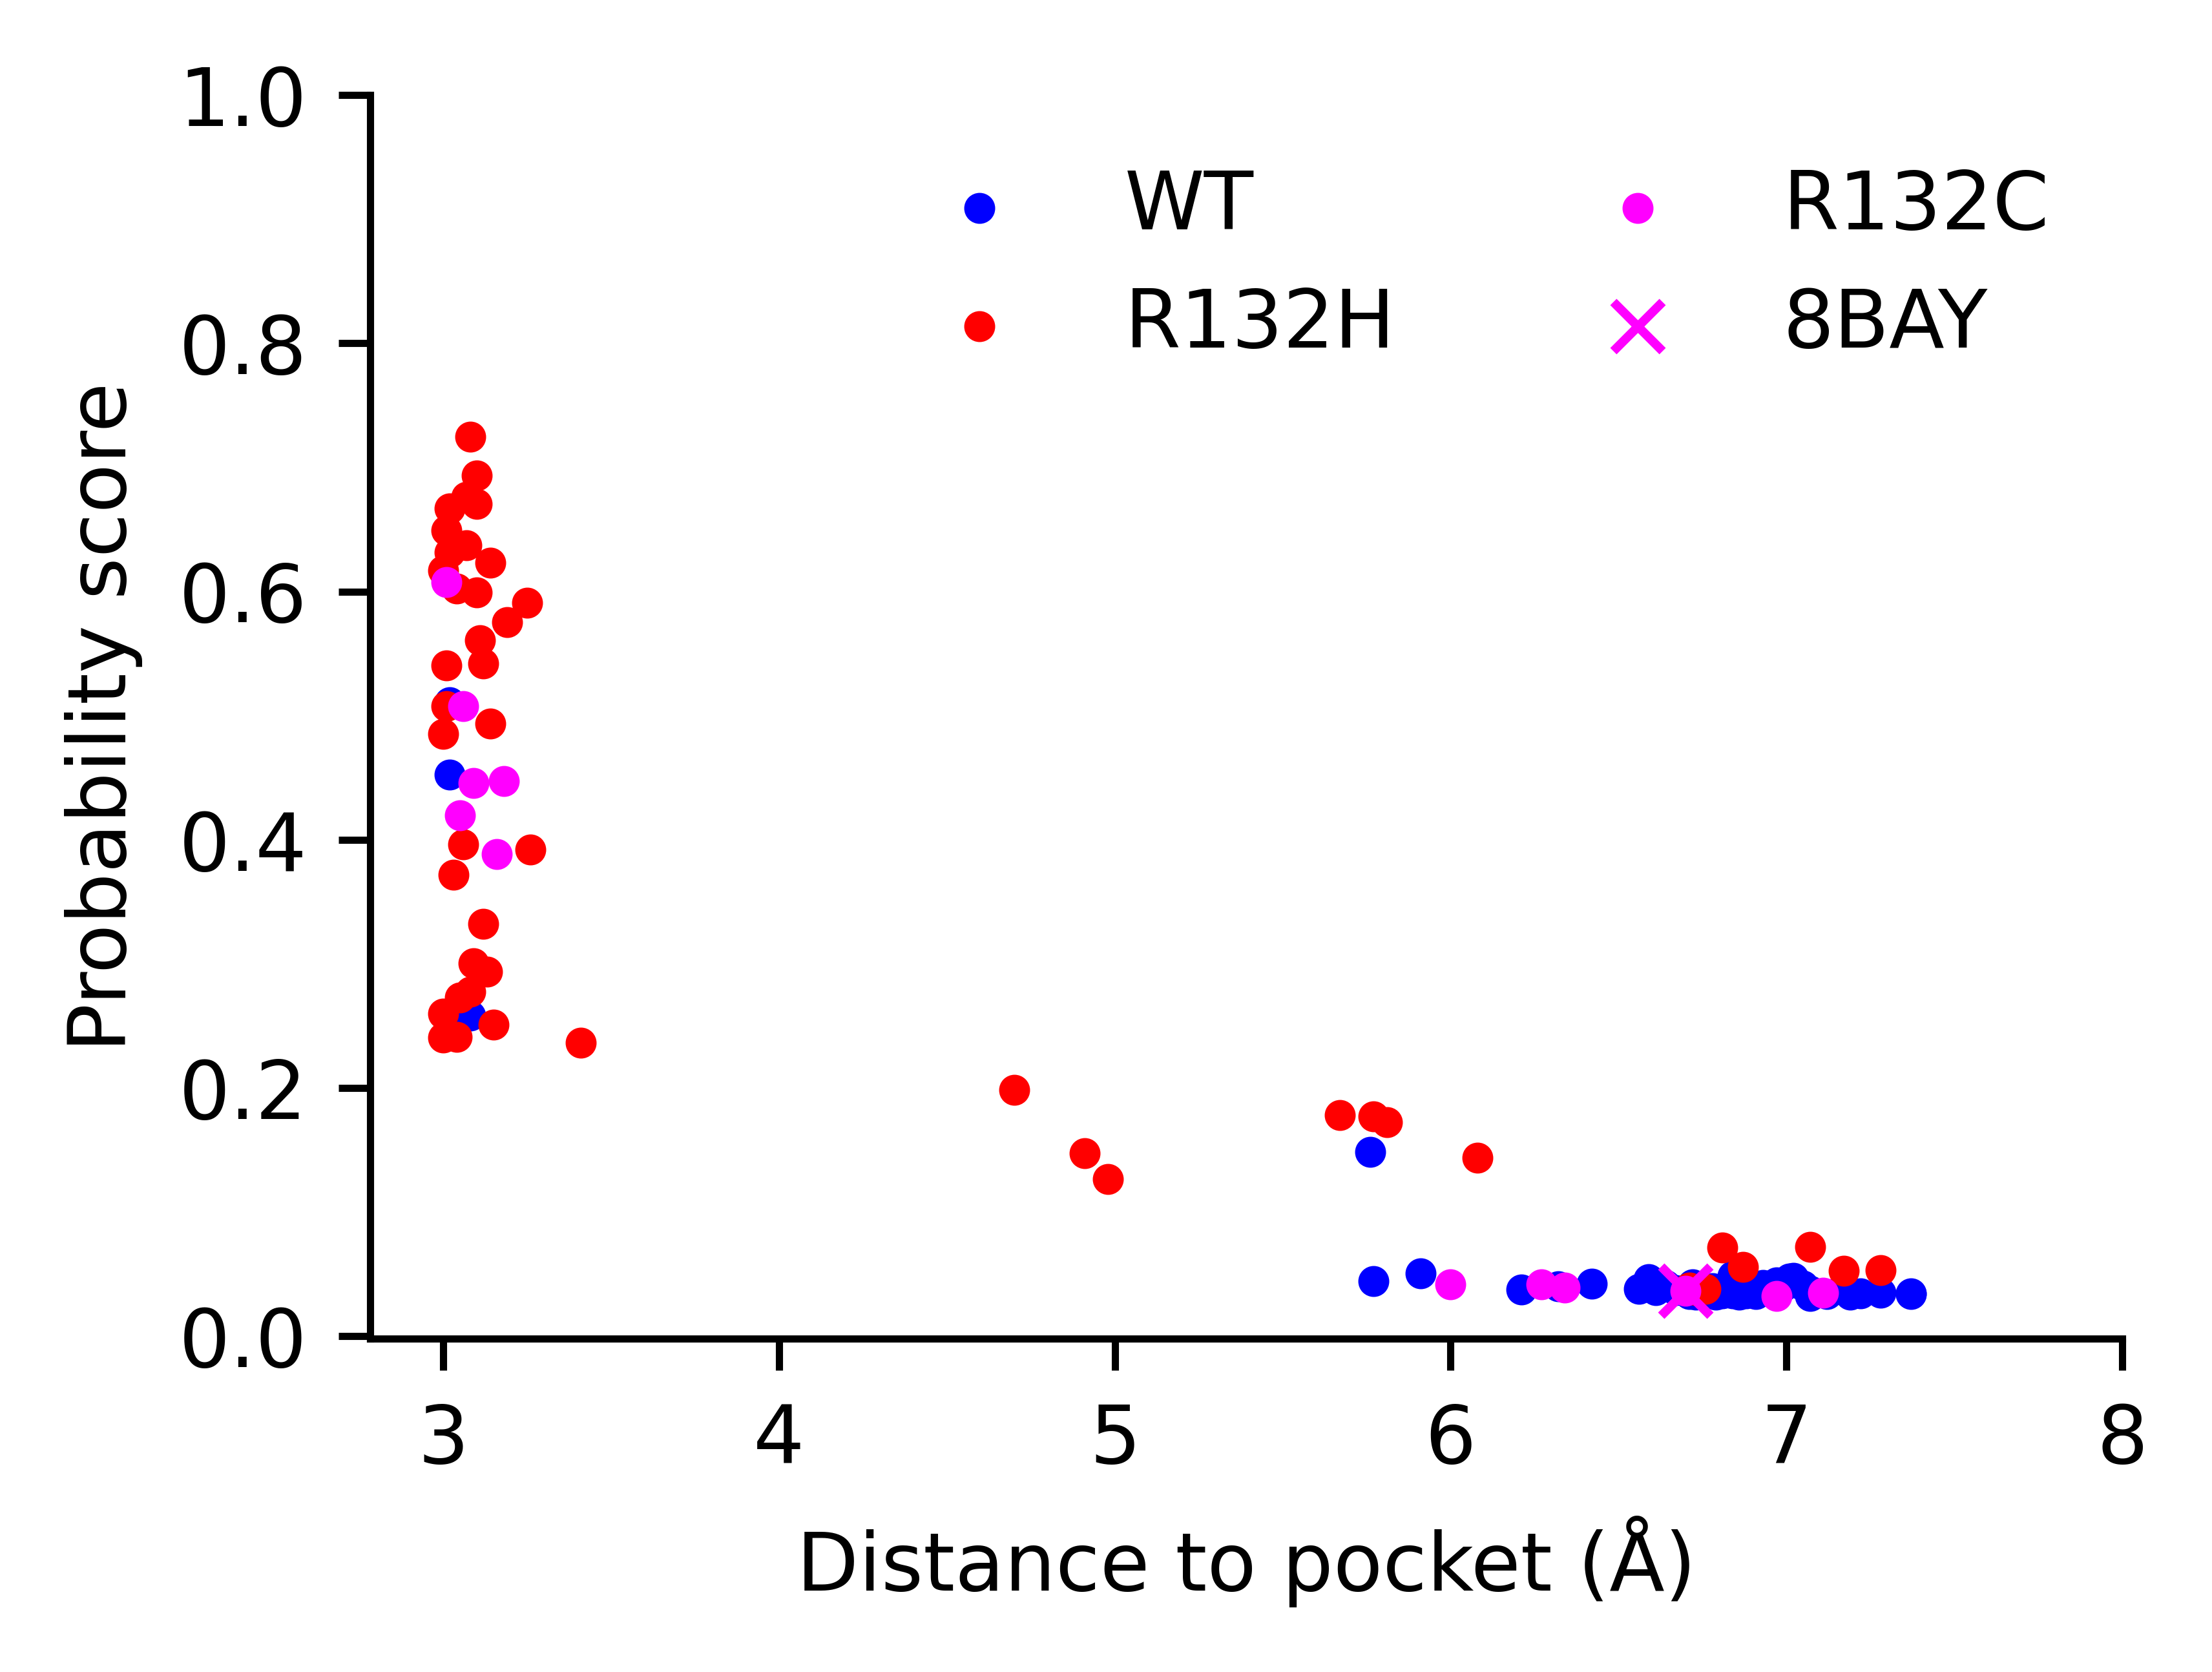

In [249]:
with plt.style.context('default'):
    mpl.rcParams['text.color'] = 'black'
    mpl.rc('font', **font)
    fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=1000)
    
    r132_indices = O75874[O75874['132'] == 'ARG'].index
    r132 = O75874.iloc[r132_indices]
    r132_score = pos_mul_g20_mean['O75874_C269'][r132_indices]
    plt.scatter(r132.sg_pocket_d1, r132_score, s=6, c='blue', marker='o', label='WT')
    
    h132_indices = O75874[O75874['132'] == 'HIS'].index
    h132 = O75874.iloc[h132_indices]
    h132_score = pos_mul_g20_mean['O75874_C269'][h132_indices]
    plt.scatter(h132.sg_pocket_d1, h132_score, s=6, c='red', marker='o', label='R132H')
    
    c132_indices = O75874[O75874['132'] == 'CYS'].index
    c132 = O75874.iloc[c132_indices]
    c132_score = pos_mul_g20_mean['O75874_C269'][c132_indices]
    plt.scatter(c132.sg_pocket_d1, c132_score, s=6, c='magenta', marker='o', label='R132C')
    
    unique_index = O75874[(O75874.pdb == '8BAY') & (O75874.chain == 'C')].index
    unique = O75874.iloc[unique_index]
    unique_score = pos_mul_g20_mean['O75874_C269'][unique_index]
    plt.scatter(unique.sg_pocket_d1, unique_score, s=30, c='magenta', marker='x', linewidths=1, label='8BAY')
    
#     plt.scatter(O75874.total_side, pos_mul_g20_mean['O75874_C269'], s=6, c='k')
    ax.set_xlabel(r'Distance to pocket (Å)', fontsize=9)
    ax.set_ylabel('Probability score', fontsize=9)
    ax.set_xticks([3, 4, 5, 6, 7, 8], fontsize=9)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=9)
    ax.spines[['right', 'top']].set_visible(False)
    plt.legend(ncol=2, frameon=False, fontsize=9)
    plt.show()
    plt.savefig('O75874_C269.pdf')
    plt.close()


In [58]:
# Avearge over models

# Multi
res_scores = defaultdict(list)
for model, probs in neg_mul_g5_probs.items():
    for res, scores in probs.items():
        res_scores[res].append(scores)
neg_mul_g5_mean = defaultdict(list)
neg_mul_g5_std = defaultdict(list)
for res, scores in res_scores.items():
    scores = np.array(scores)
    neg_mul_g5_mean[res] = np.mean(scores, axis=0)
    neg_mul_g5_std[res] = np.std(scores, axis=0)

# Single  
res_scores = defaultdict(list)
for model, probs in neg_single_g5_probs.items():
    for res, scores in probs.items():
        res_scores[res].append(scores)
neg_single_g5_mean = defaultdict(list)
neg_single_g5_std = defaultdict(list)
for res, scores in res_scores.items():
    scores = np.array(scores)
    neg_single_g5_mean[res] = np.mean(scores, axis=0)
    neg_single_g5_std[res] = np.std(scores, axis=0)

# AF2
res_scores = defaultdict(list)
for model, probs in neg_af2_g5_probs.items():
    for res, scores in probs.items():
        res_scores[res].append(scores)
neg_af2_g5_mean = defaultdict(list)
neg_af2_g5_std = defaultdict(list)
for res, scores in res_scores.items():
    scores = np.array(scores)
    neg_af2_g5_mean[res] = np.mean(scores, axis=0)
    neg_af2_g5_std[res] = np.std(scores, axis=0)

In [59]:
len(neg_mul_g5_mean), len(neg_single_g5_mean), len(neg_af2_g5_mean)

(14, 14, 14)

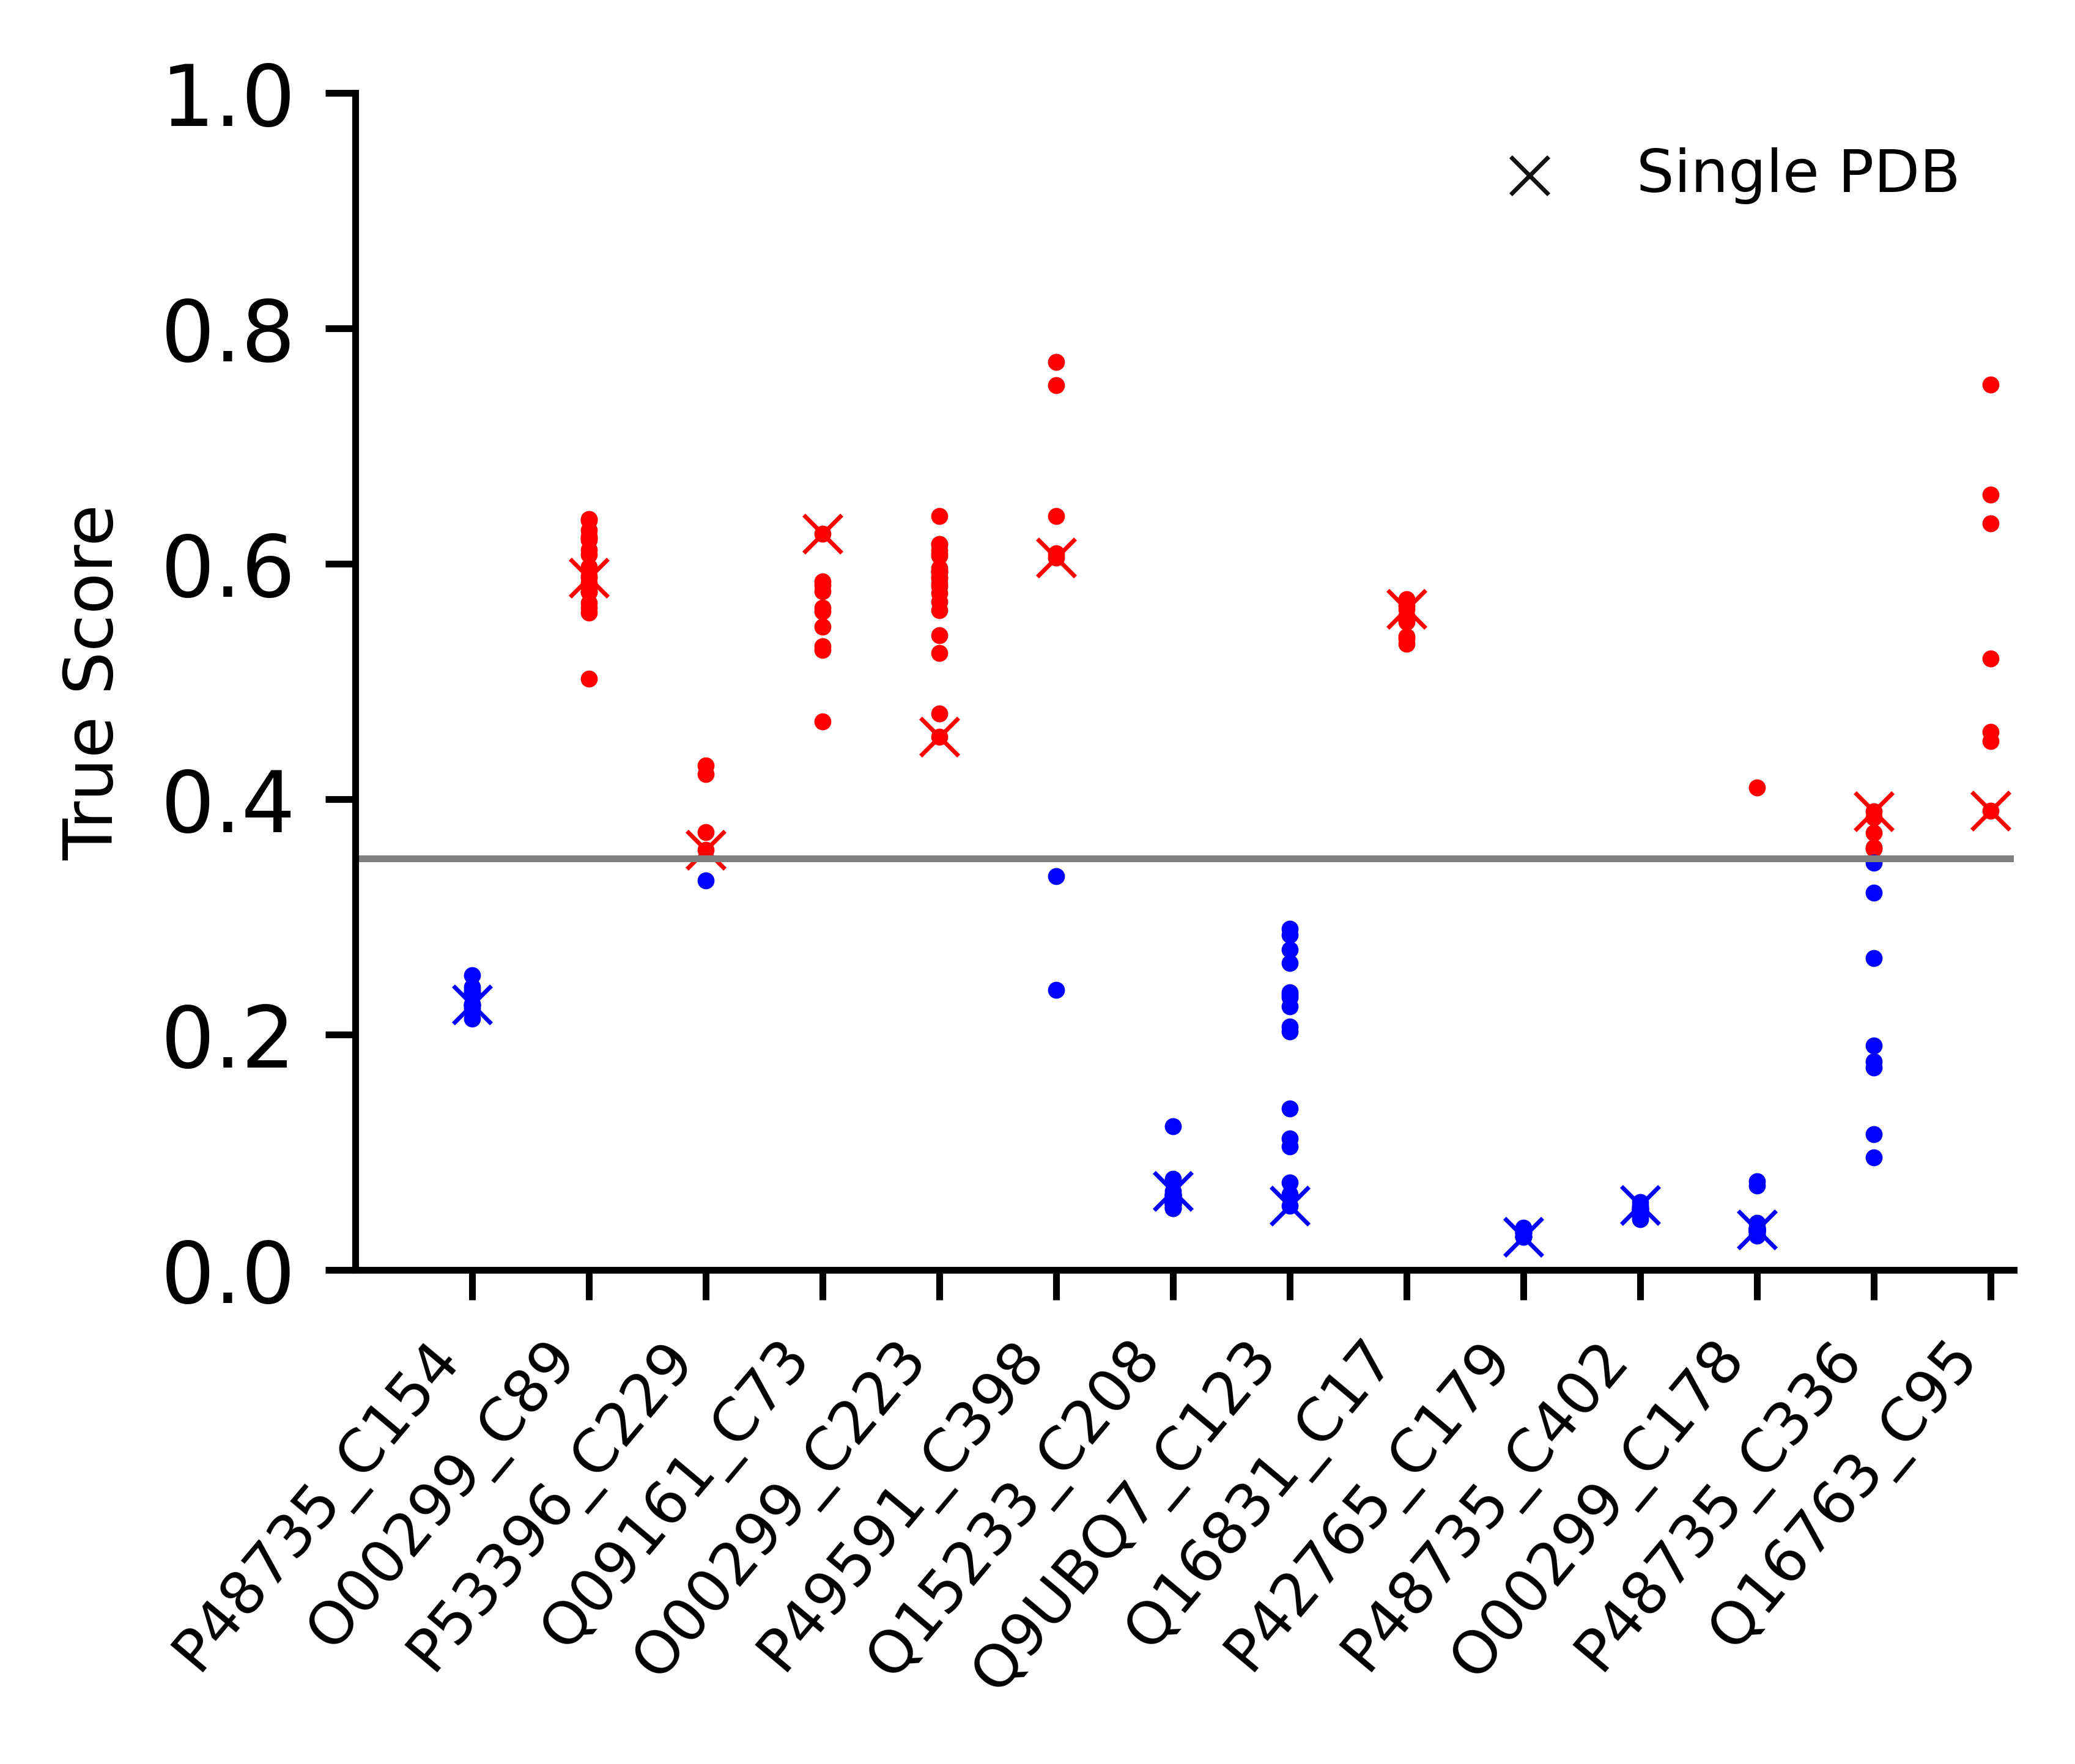

In [74]:
threshold = 0.35
with plt.style.context('default'):
    mpl.rcParams['text.color'] = 'black'
    mpl.rc('font', **font)
    fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=1000)
    for i, (residue, scores) in enumerate(neg_mul_g5_mean.items()):
        pos = [j for j in scores if j >= threshold]
        neg = [j for j in scores if j < threshold]
        af2 = neg_af2_g5_mean[residue]
        unique = neg_single_g5_mean[residue]
        x_p = [i for _ in range(len(pos))]
        x_n = [i for _ in range(len(neg))]
        x_af2 = [i]
        x_unique = [i]
        if af2 >= threshold:
            af2_color = 'magenta'
        else:
            af2_color = 'cyan'
        if unique >= threshold:
            unique_color = 'red'
        else:
            unique_color = 'blue'
        if i == 0:
            plt.scatter(x_p, pos, color='red', s=1, facecolor='white')
            plt.scatter(x_n, neg, color='blue', s=1, label=' ', facecolor='white')
            plt.scatter(x_unique, unique, marker='x', s=20, c=unique_color, label='Single PDB', facecolor='white', linewidths=0.5)
#             plt.scatter(x_af2, af2, marker='*', s=8, c=af2_color, label='AF2', facecolor='white')
        else:
            plt.scatter(x_p, pos, color='red', s=1, facecolor='k')
            plt.scatter(x_n, neg, color='blue', s=1, facecolor='k')
            plt.scatter(x_unique, unique, marker='x', s=20, c=unique_color, facecolor='k', linewidths=0.5)
#             plt.scatter(x_af2, af2, marker='*', s=8, c=af2_color, facecolor='k')
    line_x = [-1] + [j for j in range(i)] + [i+1]
    plt.plot(line_x, [0.35 for _ in range(len(line_x))], color='gray', ls='-', lw=0.8)
    plt.legend(ncol=3, frameon=False, fontsize=7)
    ax.set_ylabel('True Score', fontsize=8)
    plt.xticks([i for i in range(len(neg_mul_g5_mean))],
               [k for k in neg_mul_g5_mean.keys()],
               rotation=50,
               ha='right',
               fontsize=7,
              )
    plt.ylim([0.0, 1.0])
    plt.xlim([-1, len(line_x)-1.8])
    ax.spines[['right', 'top']].set_visible(False)
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('white')
    leg.legendHandles[1].set_color('k')
#     leg.legendHandles[2].set_color('k')
    plt.show()
    plt.close()
#     break